###### Script to train one LDA Model with defined configuration
** **
### LDA Model Implementation

1. [Loading Data](#data_loading)
2. [Data Cleaning](#data_cleaning)
3. [Data Exploration](#data_exploration)
4. [Data Preparation](#data_preparation)
5. [LDA Model Training](#lda_model_training)
6. [Analyzing LDA Model](#model_analyzing)
7. [Prediction with Model](#model_prediction)

In [27]:
# Importing needed modules and functions
import pandas as pd
import re
import os
import numpy as np
import shutil
from datetime import date
from wordcloud import WordCloud
from pprint import pprint
from scipy import spatial

import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import similarities
import gensim.corpora as corpora

import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import task2a_prep_functions as p

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Henryy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Step 1: Loading Data <a id="data_loading"></a>
** **

In [28]:
# Read data from task 1
data = pd.read_csv('../data/results_df_prep_all.csv')

# Print out the first rows of data
data.head()

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,Link,Place,Content,Country,Continent,sentences,tokens_full,tokens_small,tokens_full_lower,...,NE_preprocessed,sent_prepcorcessed_only_nouns,sent_without_NE,no_NE_attractions,no_NE_attractions_plain,no_NE_attractions_plain_unique,no_NE_attractions_plain_unique_dict,no_NE_attractions_categories_count,all_not_ne_possible,assignment_NE_notNE
0,0,https://www.roughguides.com/usa/hawaii/waikiki/,Waikiki,"Built on a reclaimed swamp, two miles east of ...",usa,America,"['Built on a reclaimed swamp, two miles east o...","['Built', 'on', 'a', 'reclaimed', 'swamp', ','...","[['Built', 'on', 'a', 'reclaimed', 'swamp', ',...","['built', 'on', 'a', 'reclaimed', 'swamp', ','...",...,"[['kalakaua', 'avenue'], ['mile'], ['lazy', 'd...","['build', 'reclaim', 'swamp', 'mile', 'east', ...","['build', 'reclaim', 'swamp', 'east', 'downtow...","[('swamp', 'geographic_attraction'), ('island'...","['swamp', 'island', 'city', 'sea', 'shop', 'na...","['city', 'swamp', 'narrow', 'garden', 'sea', '...","{'city': 1, 'swamp': 1, 'narrow': 1, 'garden':...","{'architectural_attraction': 1, 'entertainment...","['swamp', 'honolulu', 'waikiki', 'island', 'ci...","[('Honolulu', 'waikiki'), ('Waikiki', 'island'..."
1,1,https://www.roughguides.com/usa/florida/florid...,The Florida Keys,"Folklore, films and widespread hearsay have gi...",usa,America,"['Folklore, films and widespread hearsay have ...","['Folklore', ',', 'films', 'and', 'widespread'...","[['Folklore', ',', 'films', 'and', 'widespread...","['folklore', ',', 'films', 'and', 'widespread'...",...,"[['hour'], ['florida', 'reef'], ['key'], ['afr...","['folklore', 'film', 'hearsay', 'florida', 'ke...","['folklore', 'film', 'hearsay', 'chain', 'isla...","[('island', 'geographic_attraction'), ('fishin...","['island', 'fishing', 'dive', 'coast', 'mollus...","['bear', 'town', 'milk', 'concoction', 'fritte...","{'bear': 1, 'town': 2, 'milk': 1, 'concoction'...","{'animal_attraction': 2, 'architectural_attrac...","['island', 'cuba', 'beach', 'usa', 'fishing', ...","[('Cuba', 'beach'), ('Key West', 'usa'), ('Flo..."
2,2,https://www.roughguides.com/usa/rockies/yellow...,Yellowstone National Park,America’s oldest and easily its most famous na...,usa,America,['America’s oldest and easily its most famous ...,"['America', '’', 's', 'oldest', 'and', 'easily...","[['America', '’', 's', 'oldest', 'and', 'easil...","['america', '’', 's', 'oldest', 'and', 'easily...",...,"[['year'], ['summer'], ['canyon'], ['america']...","['america', 'park', 'yellowstone', 'park', 'at...","['attract', 'visitor', 'reason', 'sheer', 'div...","[('mountain', 'geographic_attraction'), ('mead...","['mountain', 'meadow', 'grizzly', 'bear', 'bis...","['bear', 'marmot', 'wolf', 'buffalo', 'bison',...","{'bear': 1, 'marmot': 1, 'wolf': 1, 'buffalo':...","{'animal_attraction': 10, 'geographic_attracti...","['america', 'park', 'yellowstone', 'park', 'ye...","[('America', 'park'), ('YELLOWSTONE NATIONAL P..."
3,3,https://www.roughguides.com/usa/hawaii/big-isl...,The Big Island,Although the Big Island of Hawaii could hold a...,usa,America,['Although the Big Island of Hawaii could hold...,"['Although', 'the', 'Big', 'Island', 'of', 'Ha...","[['Although', 'the', 'Big', 'Island', 'of', 'H...","['although', 'the', 'big', 'island', 'of', 'ha...",...,"[['hawaii'], ['kamehameha'], ['puuhonua', 'hon...","['island', 'hawaii', 'hold', 'island', 'room',...","['hold', 'room', 'spare', 'population', 'town'...","[('town', 'architectural_attraction'), ('fair'...","['town', 'fair', 'restaurant', 'town', 'resort...","['town', 'beachfront', 'restaurant', 'shore', ...","{'town': 4, 'beachfront': 1, 'restaurant': 1, ...","{'architectural_attraction': 5, 'entertainment...","['island', 'island', 'town', 'oahu', 'maui', '...","[('the Big Island of Hawaii', 'island'), ('Oah..."
4,4,https://www.roughguides.com/usa/great-plains/,The Great Plains Travel Guide,The rolling hills and vast grasslands of the G...,usa,America,['The rolling hills and vast grasslands of the...,

#### Step 2: Data Cleaning <a id="data_cleaning"></a>
** **

In [29]:
# Add place name as title to beginning of content
data["content"] = data["Place"] + '. ' + data["Content"]

# Print out the first rows of data
data.head()

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,Link,Place,Content,Country,Continent,sentences,tokens_full,tokens_small,tokens_full_lower,...,sent_prepcorcessed_only_nouns,sent_without_NE,no_NE_attractions,no_NE_attractions_plain,no_NE_attractions_plain_unique,no_NE_attractions_plain_unique_dict,no_NE_attractions_categories_count,all_not_ne_possible,assignment_NE_notNE,content
0,0,https://www.roughguides.com/usa/hawaii/waikiki/,Waikiki,"Built on a reclaimed swamp, two miles east of ...",usa,America,"['Built on a reclaimed swamp, two miles east o...","['Built', 'on', 'a', 'reclaimed', 'swamp', ','...","[['Built', 'on', 'a', 'reclaimed', 'swamp', ',...","['built', 'on', 'a', 'reclaimed', 'swamp', ','...",...,"['build', 'reclaim', 'swamp', 'mile', 'east', ...","['build', 'reclaim', 'swamp', 'east', 'downtow...","[('swamp', 'geographic_attraction'), ('island'...","['swamp', 'island', 'city', 'sea', 'shop', 'na...","['city', 'swamp', 'narrow', 'garden', 'sea', '...","{'city': 1, 'swamp': 1, 'narrow': 1, 'garden':...","{'architectural_attraction': 1, 'entertainment...","['swamp', 'honolulu', 'waikiki', 'island', 'ci...","[('Honolulu', 'waikiki'), ('Waikiki', 'island'...","Waikiki. Built on a reclaimed swamp, two miles..."
1,1,https://www.roughguides.com/usa/florida/florid...,The Florida Keys,"Folklore, films and widespread hearsay have gi...",usa,America,"['Folklore, films and widespread hearsay have ...","['Folklore', ',', 'films', 'and', 'widespread'...","[['Folklore', ',', 'films', 'and', 'widespread...","['folklore', ',', 'films', 'and', 'widespread'...",...,"['folklore', 'film', 'hearsay', 'florida', 'ke...","['folklore', 'film', 'hearsay', 'chain', 'isla...","[('island', 'geographic_attraction'), ('fishin...","['island', 'fishing', 'dive', 'coast', 'mollus...","['bear', 'town', 'milk', 'concoction', 'fritte...","{'bear': 1, 'town': 2, 'milk': 1, 'concoction'...","{'animal_attraction': 2, 'architectural_attrac...","['island', 'cuba', 'beach', 'usa', 'fishing', ...","[('Cuba', 'beach'), ('Key West', 'usa'), ('Flo...","The Florida Keys. Folklore, films and widespre..."
2,2,https://www.roughguides.com/usa/rockies/yellow...,Yellowstone National Park,America’s oldest and easily its most famous na...,usa,America,['America’s oldest and easily its most famous ...,"['America', '’', 's', 'oldest', 'and', 'easily...","[['America', '’', 's', 'oldest', 'and', 'easil...","['america', '’', 's', 'oldest', 'and', 'easily...",...,"['america', 'park', 'yellowstone', 'park', 'at...","['attract', 'visitor', 'reason', 'sheer', 'div...","[('mountain', 'geographic_attraction'), ('mead...","['mountain', 'meadow', 'grizzly', 'bear', 'bis...","['bear', 'marmot', 'wolf', 'buffalo', 'bison',...","{'bear': 1, 'marmot': 1, 'wolf': 1, 'buffalo':...","{'animal_attraction': 10, 'geographic_attracti...","['america', 'park', 'yellowstone', 'park', 'ye...","[('America', 'park'), ('YELLOWSTONE NATIONAL P...",Yellowstone National Park. America’s oldest an...
3,3,https://www.roughguides.com/usa/hawaii/big-isl...,The Big Island,Although the Big Island of Hawaii could hold a...,usa,America,['Although the Big Island of Hawaii could hold...,"['Although', 'the', 'Big', 'Island', 'of', 'Ha...","[['Although', 'the', 'Big', 'Island', 'of', 'H...","['although', 'the', 'big', 'island', 'of', 'ha...",...,"['island', 'hawaii', 'hold', 'island', 'room',...","['hold', 'room', 'spare', 'population', 'town'...","[('town', 'architectural_attraction'), ('fair'...","['town', 'fair', 'restaurant', 'town', 'resort...","['town', 'beachfront', 'restaurant', 'shore', ...","{'town': 4, 'beachfront': 1, 'restaurant': 1, ...","{'architectural_attraction': 5, 'entertainment...","['island', 'island', 'town', 'oahu', 'maui', '...","[('the Big Island of Hawaii', 'island'), ('Oah...",The Big Island. Although the Big Island of Haw...
4,4,https://www.roughguides.com/usa/great-plains/,The Great Plains Travel Guide,The rolling hills and vast grasslands of the G...,usa,America,['The rolling hills and vast grasslands of the...,"['The', 'ro

In [30]:
# Remove the not needed columns from dataframe
data = data.loc[: , ['Place', 'content']].copy()

# Print out the first rows of data
data.head()

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Place,content
0,Waikiki,"Waikiki. Built on a reclaimed swamp, two miles..."
1,The Florida Keys,"The Florida Keys. Folklore, films and widespre..."
2,Yellowstone National Park,Yellowstone National Park. America’s oldest an...
3,The Big Island,The Big Island. Although the Big Island of Haw...
4,The Great Plains Travel Guide,The Great Plains Travel Guide. The rolling hil...


In [31]:
# Remove punctuation
data['content_processed'] = data['content'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert text to lowercase
data['content_processed'] = data['content_processed'].map(lambda x: x.lower())

# Print out the first rows of data
data['content_processed'].head()

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-31-60f5b9387ec1>:2: DeprecationWarning: invalid escape sequence \.
  data['content_processed'] = data['content'].map(lambda x: re.sub('[,\.!?]', '', x))


0    waikiki built on a reclaimed swamp two miles e...
1    the florida keys folklore films and widespread...
2    yellowstone national park america’s oldest and...
3    the big island although the big island of hawa...
4    the great plains travel guide the rolling hill...
Name: content_processed, dtype: object

#### Step 3: Data Exploration <a id="data_exploration"></a>
** **

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


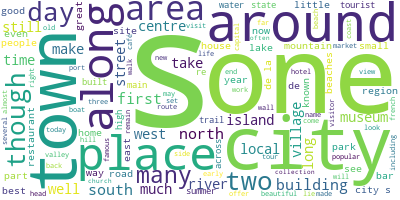

In [32]:
# Join the content of all rows together to one huge string
content_string = ','.join(list(data['content_processed'].values))

# Create a wordcloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud based on the content string
wordcloud.generate(content_string)

# Visualize the word cloud
wordcloud.to_image()

#### Step 4: Data Preparation (especially for LDA analysis) <a id="data_preparation"></a>
** **

In [33]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'de', 'km', 'one', 'two'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield simple_preprocess(str(sentence), deacc=True) # -> True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Tokenizing and remove punctuation of processed content
data_list = data.content_processed.values.tolist()
data_words = list(sent_to_words(data_list))

# Lemmatization of processed content
data_lemmatize = p.lemmatize_to_list([data_words])[0]

# Remove stop words of processed content
data_words = remove_stopwords(data_lemmatize)

# Print out results
print(data_words[:1][0][:30])

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['waikiki', 'build', 'reclaimed', 'swamp', 'mile', 'east', 'downtown', 'honolulu', 'waikiki', 'nearly', 'island', 'separate', 'city', 'sea', 'ala', 'wai', 'canal', 'site', 'may', 'venerable', 'day', 'raisond', 'etre', 'rampant', 'commercialism', 'could', 'survive', 'little', 'money', 'would']


In [34]:
# Create Dictionary based on the document texts
id2word = corpora.Dictionary(data_words)

# Create Corpus (Term Document Frequency) based on the document texts
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

# Print results
print(corpus[:1][0][:30])
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 3)]
[[('ala', 1), ('along', 2), ('always', 1), ('apart', 1), ('around', 1), ('avenue', 1), ('beach', 1), ('build', 1), ('canal', 1), ('canoe', 1), ('centre', 1), ('city', 1), ('commercialism', 1), ('comprehensive', 1), ('could', 1), ('day', 2), ('downtown', 1), ('east', 1), ('edge', 1), ('etre', 1), ('find', 1), ('first', 1), ('freely', 1), ('frenzy', 1), ('garden', 1), ('go', 1), ('guide', 1), ('hawaiian', 1), ('honolulu', 1), ('island', 3), ('kalakaua', 1), ('lazy', 1), ('lesson', 1), ('line', 1), ('little', 2), ('make', 1), ('may', 1), ('mile', 1), ('money', 1), ('narrow', 1), ('nearby', 1), ('nearly', 1), ('nothing', 1), ('outrigger', 1), ('overview', 1), ('parallel', 1), ('pedestrian', 1), ('place', 2), ('pleasant', 1), ('point'

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Step 5: LDA model training <a id="lda_model_training"></a>
** **

Training with 'ldamulticore' for using all CPU cores to parallelize and speed up model training.

> ldamulticore: An optimized implementation of the LDA algorithm, able to harness the power of multicore CPUs. Follows the similar API 'ldamodel'

> alpha: a parameter that controls the behavior of the Dirichlet prior used in the model. If set to a value close to zero, the model will tend to use a fewer number of topics per document; conversely, if it's a higher value, then there will be more topics per document. If set to auto, this parameter will be tuned automatically.

In [35]:
# Define number of topics and model name (for saving) for LDA Model
num_topics = 10

# Define Hyperparameters (alpha/beta) for LDA Model
alpha = False
eta = False

# Build LDA Model with corpus and dictionary of the document texts based on defined Hyperparameters
if alpha and eta: # > alpha & beta
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           alpha='symmetric',
                                           eta='symmetric')

elif alpha: # > alpha represents document-topic density
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           alpha='symmetric')

elif eta: # > beta represents topic-word density
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           eta='symmetric')
else: # > without Hyperparameters
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.006*"city" + 0.005*"town" + 0.004*"around" + 0.003*"area" + 0.003*"place" '
  '+ 0.003*"also" + 0.003*"well" + 0.003*"take" + 0.003*"main" + '
  '0.003*"beach"'),
 (1,
  '0.006*"city" + 0.004*"place" + 0.003*"century" + 0.003*"day" + '
  '0.003*"around" + 0.003*"area" + 0.003*"many" + 0.003*"town" + 0.003*"also" '
  '+ 0.003*"well"'),
 (2,
  '0.006*"city" + 0.004*"park" + 0.003*"town" + 0.003*"day" + 0.003*"century" '
  '+ 0.003*"take" + 0.003*"first" + 0.003*"lake" + 0.003*"san" + '
  '0.003*"around"'),
 (3,
  '0.008*"city" + 0.004*"town" + 0.004*"around" + 0.004*"place" + '
  '0.004*"century" + 0.003*"make" + 0.003*"beach" + 0.003*"also" + '
  '0.003*"year" + 0.003*"though"'),
 (4,
  '0.007*"city" + 0.004*"town" + 0.004*"century" + 0.004*"day" + 0.003*"place" '
  '+ 0.003*"also" + 0.003*"make" + 0.003*"around" + 0.003*"best" + '
  '0.003*"centre"'),
 (5,
  '0.006*"city" + 0.005*"town" + 0.004*"around" + 0.004*"lake" + 0.004*"day" + '
  '0.003*"place" + 0.003*"beach" + 0.003

#### Step 6: Analyzing LDA model <a id="model_analyzing"></a>
** **
One approach to find optimum number of topics is build many LDA models with different values of number of topics and pick the one that gives highest coherence value.

In [36]:
# defining model name for saving purpose
today = date.today()
d1 = today.strftime('%d%m%Y')
model_name = f'{d1}_' + f'{num_topics}' + 'topics'

# Visualize the topics
pyLDAvis.enable_notebook()

path = f'../results/{model_name}/'
if not os.path.exists(path):
    os.mkdir(f'../results/{model_name}/')
LDAvis_data_filepath = os.path.join(f'../results/{model_name}/lda_vis_prepared_' + str(num_topics) + f'_alpha{alpha}_beta{eta}')

# execute visualization prep yourself
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, f'../results/{model_name}/lda_vis_prepared_' + str(num_topics) + f'_alpha{alpha}_beta{eta}.html')

LDAvis_prepared

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.006224 -0.006299       1        1  36.377371
5     -0.009416 -0.004570       2        1  17.144597
4     -0.000197  0.000463       3        1  12.557379
3      0.001058  0.003890       4        1  12.093466
9      0.006207  0.001439       5        1   9.731160
8      0.002008 -0.001077       6        1   7.131154
2     -0.003083  0.005085       7        1   1.772867
0      0.000381  0.002226       8        1   1.726039
7     -0.000507 -0.001330       9        1   0.936525
1     -0.002677  0.000174      10        1   0.529442, topic_info=       Term        Freq       Total Category  logprob  loglift
11     city  748.000000  748.000000  Default  30.0000  30.0000
245    town  515.000000  515.000000  Default  29.0000  29.0000
4    around  423.000000  423.000000  Default  28.0000  28.0000
15      day  310.000000  310.000000  Default  27.0000  27.0000
47    place  356.000000  356.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
931    take    1.234678  292.390214  Topic10  -6.0691  -0.2262
245    town    1.492844  515.754769  Topic10  -5.8793  -0.6038
328    park    0.990302  194.393451  Topic10  -6.2897  -0.0385
924   small    0.934476  200.246924  Topic10  -6.3477  -0.1262
6     beach    0.966568  275.891944  Topic10  -6.3139  -0.4129

[806 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
357        1  0.326787    across
357        2  0.199703    across
357        3  0.145239    across
357        4  0.136161    across
357        5  0.099851    across
...      ...       ...       ...
12538      3  0.093772  zeppelin
12538      4  0.093772  zeppelin
1172       2  0.180986      zion
1172       4  0.542958      zion
1172       5  0.180986      zion

[1822 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 5, 4, 10, 9, 3, 1, 8, 2])

In [37]:
# Compute Perplexity -> lower the perplexity better the model.
perplexity = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity)

# Compute Coherence Score -> higher the topic coherence, the topic is more human interpretable.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatize, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# save Perplexity and Coherence Score to LDA Model results directory
with open(f'../results/{model_name}/lda_vis_prepared_' + str(num_topics) + f'_alpha{alpha}_beta{eta}_scores.txt', 'w') as f:
    f.write(f'Perplexity: {perplexity}\n')
    f.write(f'Coherence Score: {coherence_lda}\n')
    f.close()

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -9.529847186723707

Coherence Score:  0.2547076325040827


In [38]:
# calculate score for each topic per document
def get_doc_topic(corpus, model):
    doc_topic = []
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=0))
    return doc_topic

matrix = get_doc_topic(corpus, lda_model)

# reformat output to match matrix from LSA approach
matrix_df = pd.DataFrame(matrix)
matrix_df = matrix_df.apply(lambda x: [y[1] for y in x])

# safe matrix as csv
matrix_df.to_csv(f'../results/{model_name}/lda_vis_prepared_' + str(num_topics) + f'_alpha{alpha}_beta{eta}_matrix.csv', index=False, header=False)

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Step 7: Predicting with LDA model (& save result)<a id="model_prediction"></a>
** **

In [52]:
# get place of the closest document for each word
# transform svd matrix to spacial KDtree
tree = spatial.KDTree(matrix_df)

# transform a list of words with the fitted model to get their vector-representation
input = [['sun', 'beach'], ['city', 'town'], ['mountain', 'hiking']]
# Todo: Run Preprocessing over input


# transform words with dict to bow
input_bow = [id2word.doc2bow(words) for words in input]

input_topics = lda_model.__getitem__(input_bow)
# reformat to keep just values in tuples
input_vecs = []
for line in input_topics:
    input_vecs.append([y[1] for y in line])

# get closest document vector for each word vector
with open(f'../results/{model_name}/lda_vis_prepared_' + str(num_topics) + f'_alpha{alpha}_beta{eta}_prediction.txt', 'w') as f:
    for i, input_vec in enumerate(input_vecs):
        query = tree.query(input_vec)
        # save prediction to LDA Model results directory
        f.write(f'{input[i]} > "{data.Place[query[1]]}" - Distance: {query[0]}\n')
    f.close()

C:\Users\Henryy\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
